# How to convert new Xenotest kJ/m2 to luxhours 

*What is the meaning of the kJ/m2 light dose as reported by the new Xeno-test equipment? And how can this unit be converted to luxhours?*

## Background information

Atlas [Xenotest](https://www.atlas-mts.com/products/standard-instruments/xenon-weathering/xenotest/440) equipment is used in our lab for artificial light aging experiments. The filtered xenon light simulates sunlight through window glass. After a given exposure experiment, the instrument reports the total dose of UV energy per surface area in units of kilo Joule per square meter (kJ/m2). For heritage scientists it is more meaningful to report a light exposure dose in units of lux hours. 

In this notebook I explain how to calculate the conversion factor. The calculation of the conversion factor is detailed below. It is instructive to read about the theoretical background of lumen and lux calculations on wikipedia: https://en.wikipedia.org/wiki/Luminosity_function.  

In order to repeat the calculations below you need to install the color science python package and scipy: 

    $ pip install colour-science   
    
    $ pip install scipy 

It helps to study the documentation on luminous efficiency: 

https://colour.readthedocs.io/en/v0.3.15/_modules/colour/colorimetry/photometry.html#luminous_efficacy

https://colour.readthedocs.io/en/v0.3.15/index.html#luminous-efficiency

## Calculation 

Note that the spectral power distributions and weight functions that we need to work with all list different wavelength values. In order to easily multiply them and determine their surface areas we need to interpolate them all (and make them zero everywhere else). 

In [21]:
# %matplotlib inline 
import colour
import matplotlib.pyplot as plt 
import numpy as np
#import re
import scipy.interpolate as sip 
#plt.ioff()

def interpolate(x, y): 
    '''Interpolate spectral power distribution and make zero outside. 
    
    Arguments: 
        x: list of floats (length n) 
          List of wavelengths (nm)
        y: list of floats (length n
          List of corresponding intensity values)
          
    Returns: 
        ipol: interpolation object'''
    
    ipol = sip.interp1d(x, y, bounds_error=False, fill_value=0)
    
    return ipol 

The calculation is based on the spectral distribution for a xenon light source behind glass as reported by Atlas. Note the cut-off wavelength of 320 nm. 

In [19]:
xeno_nm = [272.,  274.,  276.,  278.,  280.,  282.,  284.,  286.,  288.,
           290.,  292.,  294.,  296.,  298.,  300.,  302.,  304.,  306.,
           308.,  310.,  312.,  314.,  316.,  318.,  320.,  322.,  324.,
           326.,  328.,  330.,  332.,  334.,  336.,  338.,  340.,  342.,
           344.,  346.,  348.,  350.,  352.,  354.,  356.,  358.,  360.,
           362.,  364.,  366.,  368.,  370.,  372.,  374.,  376.,  378.,
           380.,  382.,  384.,  386.,  388.,  390.,  392.,  394.,  396.,
           398.,  400.,  402.,  404.,  406.,  408.,  410.,  412.,  414.,
           416.,  418.,  420.,  422.,  424.,  426.,  428.,  430.,  432.,
           434.,  436.,  438.,  440.,  442.,  444.,  446.,  448.,  450.,
           452.,  454.,  456.,  458.,  460.,  462.,  464.,  466.,  468.,
           470.,  472.,  474.,  476.,  478.,  480.,  482.,  484.,  486.,
           488.,  490.,  492.,  494.,  496.,  498.,  500.,  520.,  530.,
           540.,  550.,  560.,  570.,  580.,  590.,  600.,  610.,  620.,
           630.,  640.,  650.,  660.,  670.,  680.,  690.,  700.,  710.,
           720.,  730.,  740.,  750.,  760.,  770.,  780.,  790.,  800.] 

xeno_power = [0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
              0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
              0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.02,  0.04,  0.06,  0.08,
              0.11,  0.15,  0.18,  0.22,  0.27,  0.32,  0.39,  0.43,  0.49,
              0.55,  0.59,  0.64,  0.7 ,  0.74,  0.79,  0.82,  0.84,  0.92,
              0.94,  0.98,  1.03,  1.13,  1.1 ,  1.07,  1.09,  1.1 ,  1.11,
              1.17,  1.17,  1.12,  1.12,  1.14,  1.19,  1.22,  1.56,  1.69,
              1.38,  1.37,  1.37,  1.46,  1.55,  1.72,  1.8 ,  1.8 ,  1.69,
              1.73,  1.92,  1.87,  1.82,  1.8 ,  1.76,  1.82,  1.83,  1.82,
              1.87,  1.95,  2.09,  2.09,  1.96,  1.95,  1.93,  2.05,  2.59,
              2.47,  2.13,  2.46,  2.45,  2.42,  4.32,  2.45,  6.14,  3.63,
              3.53,  3.31,  2.65,  2.32,  2.39,  3.51,  3.29,  2.95,  2.4 ,
              2.42,  2.83,  3.22,  2.53,  2.41,  2.38,  2.44,  2.46,  2.47,
              2.35,  2.42,  2.13,  2.16,  1.98,  1.99,  1.48,  1.45,  1.78,
              1.86,  0.91,  1.36,  0.89,  0.61,  0.57,  0.94,  0.39,  0.69,
              0.33,  0.53,  1.11,  0.43,  1.29,  0.25,  0.57,  0.52,  0.35]

Now we create interpolation objects for the xenon spectrum, the luminous efficiency function and the UV window function (300-400 nm). 

In [25]:
xeno320_ipol = interpolate(xeno_nm, xeno_power)

lum_eff = colour.PHOTOPIC_LEFS['CIE 1924 Photopic Standard Observer']
lum_eff_ipol = interpolate(lum_eff.wavelengths, lum_eff.values)

is_uv_ipol = interpolate([300, 400], [1, 1])

In order to calculate the powers (i.e the surface areas) we interpolate the spectral functions for each nanometer and simply sum their values. 

In [27]:
x = np.arange(299, 800) # list of wavelenghts 

uv_power = xeno320_ipol(x) * is_uv_ipol(x)
uv_norm = np.sum(uv_power)

vis_power = xeno320_ipol(x) * lum_eff_ipol(x) # 'visual Watts'
vis_norm = np.sum(vis_power/uv_norm)

The visual power for a the xenotest spectrum that is uv normalized is now known: 

In [29]:
vis_norm

3.4885077279080714

In order to convert (visual) Watts into lumen you need to multiply with this funny number 683:  

In [30]:
3.49 * 683 # lumen per UV watt

2383.67

Just to check we calculate here the total surface area for the UV normalized spectrum. 

In [31]:
tot_power = np.sum(xeno320_ipol(x) / uv_norm)
tot_power

10.699518311797537

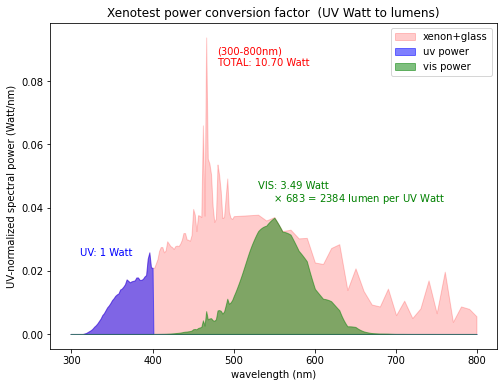

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 6])

ax.fill_between(x, xeno320_ipol(x) / uv_norm, color='r', alpha=0.2, label='xenon+glass')

ax.fill_between(x, uv_power / uv_norm, color='b', alpha=0.5, label='uv power')

ax.fill_between(x, vis_power/uv_norm, color='g', alpha=0.5, label='vis power')

ax.legend()
ax.annotate('UV: 1 Watt', [310, 0.025], color='b')
ax.annotate('VIS: 3.49 Watt', [530, 0.046], color='g')
ax.annotate(r'     $\times$ 683 = 2384 lumen per UV Watt', [530, 0.042], color='g')
ax.annotate('(300-800nm)\nTOTAL: 10.70 Watt', [480, 0.085], color='r')


ax.set_xlabel('wavelength (nm)')
ax.set_ylabel('UV-normalized spectral power (Watt/nm)')
ax.set_title('Xenotest power conversion factor  (UV Watt to lumens)')
plt.savefig('xeno320-conversion-factor.pdf')
plt.show()

The description of the Xenotest 440 states that the lamps can deliver 40-60 W/m2. A UV intensity of 42 W/m2 would then imply a lux level of 42 x 2384 = 100128 lux. 

One last step now is to convert seconds into hours. In order to convert a uv dose of 1 kJ / m2 into lux hours, we need another conversion factor: 

    1 kJ /m2 = 1000 (UV)Watt x 1 sec / m2 
             = 1000 / 3600 (UV)Watt hour / m2
             = 2384000 / 3600 lumen hour / m2
             = 662 lux hour
    
    



In [139]:
2384000 / 3600 

662.2222222222222

In [137]:
42* 2384

100128

UV content per lumen is: 

In [33]:
1/ 2384 # Watt / lumen

0.00041946308724832214